In [1]:
from sklearn.datasets import make_classification
X, y = make_classification(
    n_samples=300,
    n_features=2,  # два признака для наглядной визуализации границ решений
    n_informative=2,
    n_redundant=0,
    random_state=42
)

In [2]:
#2. Преобразуем данные в pandas.DataFrame.
import pandas as pd
X_df= pd.DataFrame(X, columns=['feature1', 'feature2'])
X_df['target'] = y
X_df['target'].value_counts(normalize=True)

target
0    0.5
1    0.5
Name: proportion, dtype: float64

In [3]:
# 3. Реализуем функции:
# 3.1. Расчета энтропии

import numpy as np

def entropy(y):
    p = y.value_counts(normalize=True)
    entropy = -np.sum(p * np.log2(p))
    return entropy

In [4]:
# 3.2. Поиска наилучшего разбиения по признаку

# 3.2.1 Сначала определим функцию для поиска кандидатов в пороговые значения

def find_candidates_for_thresholds(x, y):
    
    unique_sorted = np.sort(np.unique(x))
    
    # Вычисляем среднее между соседними значениями   
    candidates = (unique_sorted[1:] + unique_sorted[:-1]) / 2.0
    
    return candidates

# 3.2.2. Создадим функцию, которая разбивает выборку по предикату

def split(X, y, split_params):
    j, t = split_params
    predicat = X.iloc[:, j] <= t
    X_left, y_left = X[predicat], y[predicat]
    X_right, y_right = X[~predicat], y[~predicat]
    return X_left, y_left, X_right, y_right

# 3.2.3. Cоздадим функцию, рассчитывающую взвешенную неоднородность после разбиения
# в качестве критерия информативности возьмем энтропию

def calculate_weighted_impurity(X, y, split_params, criterion):
    X_left, y_left, X_right, y_right = split(X, y, split_params)
    N, N_left, N_right  = y.size, y_left.size, y_right.size
    score = N_left / N * criterion(y_left) + N_right / N * criterion(y_right)
    return score

# 3.2.4 Определим функцию наилучшего разбиения

def best_split(X, y, criterion):
    M = X.shape[1]
    min_weighted_impurity = np.inf
    optimal_split_params = None
    for j in range(M):
        thresholds = find_candidates_for_thresholds(X.iloc[:, j], y)
        for t in thresholds:
            split_params = (j, t)
            weighted_impurity = calculate_weighted_impurity(X, y, split_params, criterion)
            if weighted_impurity < min_weighted_impurity:
                min_weighted_impurity = weighted_impurity
                optimal_split_params = split_params
    return optimal_split_params

In [6]:
# 3.3. Определим функцию рекурсивного построения дерева с ограничением по глубине (max_depth)

# 3.3.1. Создадим вспомогательный класс вершины:
class Node:
    def __init__(self, left=None, 
                 right=None, value=None, 
                 split_params=None, impurity=None,
                 samples=None, is_leaf=False):
        self.left = left
        self.right = right
        self.split_params = split_params
        self.value = value
        self.impurity = impurity
        self.samples = samples
        self.is_leaf = is_leaf
    
# функция предсказания для листа дерева решений: 
def create_leaf_prediction(y):
    value = y.mode()[0]
    return value

# 3.3.2. Напишем саму функцию рекурсивного построения дерева

def build_decision_tree(X, y, criterion, max_depth, current_depth=0):
    
    if current_depth >= max_depth:
        value = create_leaf_prediction(y)
        node = Node(
            value=value, 
            impurity=criterion(y), 
            samples=y.size,
            is_leaf=True
        )
        return node
    else:
        split_params = best_split(X, y, criterion=criterion)
        
        # Если не найдено разбиение - создаем лист
        if split_params is None:
            value = create_leaf_prediction(y)
            node = Node(
                value=value, 
                impurity=criterion(y), 
                samples=y.size,
                is_leaf=True
            )
        else:
            X_left, y_left, X_right, y_right = split(X, y, split_params)
            
            left = build_decision_tree(X_left, y_left, criterion, max_depth, current_depth + 1)
            right = build_decision_tree(X_right, y_right, criterion, max_depth, current_depth + 1)       
            node = Node(
                left=left, right=right, 
                split_params=split_params, 
                impurity=criterion(y), 
                samples=y.size
            )
    
    return node

In [7]:
# 3.4. Определим функцию для получения предсказаний по новым наблюдениям

# 3.4.1. Сначала напишем функцию, которая выдает предсказание,
# получая на входе объект из выборки и вершину

def predict_sample(node, x):
    if node.is_leaf:
        return node.value
    j, t = node.split_params
    if x[j] <= t:
        return predict_sample(node.left, x)
    else:
        return predict_sample(node.right, x)

# 3.4.2. Теперь создадим функцию, которая выводит предсказания для всех объектов в выборке
    
def predict(decision_tree, X):
    predictions = [predict_sample(decision_tree, x) for x in X.values]
    return np.array(predictions)

  Dataset  Accuracy
0   Train     0.967
1    Test     0.944


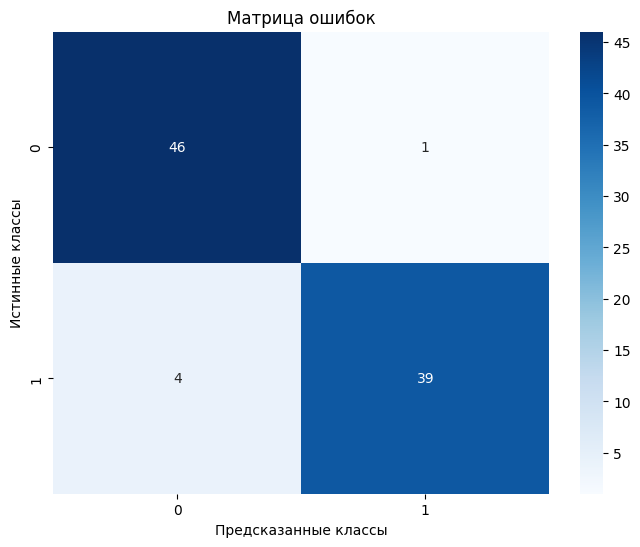

In [8]:
# 1. Разделим данные на обучающую и тестовую выборки (с помощью train_test_split),
# зафиксировав random_state=42 для воспроизводимости)

from sklearn.model_selection import train_test_split

X = X_df.drop('target', axis = 1)
y = X_df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42
)

# 2. Обучим модель
tree = build_decision_tree(X_train, y_train, criterion=entropy, max_depth=3, current_depth=0)

# 3. Выполним предсказание

y_train_pred = predict(tree, X_train)
y_test_pred = predict(tree, X_test)

# 4. Рассчитаем и проанализируем метрику accuracy_score, а также посмотрим на матрицу ошибок
# (классы сбалансированы, поэтому можем использовать accuracy_score)

from sklearn.metrics import accuracy_score, confusion_matrix

metrics_simple = {
    'Dataset': ['Train', 'Test'],
    'Accuracy': [
        accuracy_score(y_train, y_train_pred),
        accuracy_score(y_test, y_test_pred)
    ]
}

metrics_simple_df = pd.DataFrame(metrics_simple)

print(metrics_simple_df.round(3))

# Визуализируем матрицу ошибок:

cm = confusion_matrix(y_test, y_test_pred)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Матрица ошибок')
plt.ylabel('Истинные классы')
plt.xlabel('Предсказанные классы')
plt.show()

In [15]:
def tree_for_begging (X, y, random_state):
    
    
    n_samples = len(X)
    rng = np.random.RandomState(random_state)
    # Генерируем случайные индексы с возвращением
    indices = rng.choice(n_samples, size=n_samples, replace=True)
    
    # Создаем bootstrap-выборку
    X_bootstrap = X.iloc[indices].reset_index(drop=True)
    y_bootstrap = y.iloc[indices].reset_index(drop=True)
    
    #обучим модель
    tree_i = build_decision_tree(X_bootstrap, y_bootstrap, criterion=entropy, max_depth=4, current_depth=0)
    
    return tree_i
    
   

In [10]:
trees_5 = []
predictions_train_5 = {}  # словарь для предсказаний на обучающей выборке
predictions_test_5 = {}   # словарь для предсказаний на тестовой выборке

for i in range(5):
    tree = tree_for_begging(X_train, y_train)
    tree.name = f"tree_{i}"  
    trees_5.append(tree)
    
    predictions_train_5[f"tree_{i}"] = predict(tree, X_train)
    predictions_test_5[f"tree_{i}"] = predict(tree, X_test)
    
    print(f"Создано {tree.name}")
    

Создано tree_0
Создано tree_1
Создано tree_2
Создано tree_3
Создано tree_4


In [11]:
def majority_vote(predictions_dict):
   
    # Преобразуем словарь в numpy array
    all_predictions = np.array(list(predictions_dict.values()))
    
    # Голосование большинством для каждого объекта
    final_predictions = []
    for i in range(all_predictions.shape[1]):
        votes = all_predictions[:, i]  # голоса всех моделей для i-го объекта
        most_common = np.bincount(votes).argmax()  # самый частый класс
        final_predictions.append(most_common)
    
    return np.array(final_predictions)

# Применяем голосование большинством
y_ensemble_test = majority_vote(predictions_test_5)
y_ensemble_train = majority_vote(predictions_train_5)


In [12]:
metrics_simple_5 = {
    'Dataset': ['Train', 'Test'],
    'Accuracy': [
        accuracy_score(y_train, y_ensemble_train),
        accuracy_score(y_test, y_ensemble_test)
    ]
}
metrics_ans_5 = pd.DataFrame(metrics_simple_5)

print(metrics_ans_5.round(3))

  Dataset  Accuracy
0   Train     0.967
1    Test     0.944


In [13]:
n_trees_range = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
results = [{
    'n_trees': 1,
    'train_accuracy': accuracy_score(y_train, y_train_pred),
    'test_accuracy': accuracy_score(y_test, y_test_pred)
}]

for n_trees in n_trees_range:
    trees = []
    predictions_train = {}
    predictions_test = {}
    
    for i in range(n_trees):
        tree = tree_for_begging(X_train, y_train)
        predictions_train[f"tree_{i}"] = predict(tree, X_train)
        predictions_test[f"tree_{i}"] = predict(tree, X_test)
    
    y_ensemble_train = majority_vote(predictions_train)
    y_ensemble_test = majority_vote(predictions_test)
    
    train_acc = accuracy_score(y_train, y_ensemble_train)
    test_acc = accuracy_score(y_test, y_ensemble_test)
    
    results.append({
        'n_trees': n_trees,
        'train_accuracy': train_acc,
        'test_accuracy': test_acc
    })

results_df = pd.DataFrame(results)
print("ТАБЛИЦА ТОЧНОСТИ ПРИ РАЗНОМ КОЛИЧЕСТВЕ ДЕРЕВЬЕВ:")
print(results_df.round(3))

KeyboardInterrupt: 

In [ ]:
n_trees_range = [5, 10, 15, 20, 25, 30, 35] # сократим кол-во вариаций численности деревьев 
                                            # для более быстрого выполнения кода
stability_results = []

base_seed = [32, 42, 55, 107, 120, 143, 170] # для реализации различных показателей random_state
for base_seed in base_seed:
    seed_results = []
    
    for n_trees in n_trees_range:
        trees = []
        predictions_train = {}
        predictions_test = {}
    
        for i in range(n_trees):
            tree = tree_for_begging(X_train, y_train, random_state=i+base_seed)
            predictions_train[f"tree_{i}"] = predict(tree, X_train)
            predictions_test[f"tree_{i}"] = predict(tree, X_test)
    
        y_ensemble_train = majority_vote(predictions_train)
        y_ensemble_test = majority_vote(predictions_test)
    
        train_acc = accuracy_score(y_train, y_ensemble_train)
        test_acc = accuracy_score(y_test, y_ensemble_test)
        
        #запишем в seed_results 
        seed_results.append({
            'base_seed': base_seed,
            'n_trees': n_trees,
            'train_accuracy': train_acc,
            'test_accuracy': test_acc
        })
        
     # Находим оптимальное количество деревьев для данного seed
    seed_df = pd.DataFrame(seed_results)
    best_test_acc = seed_df['test_accuracy'].max()
    best_models = seed_df[seed_df['test_accuracy'] == best_test_acc]
    
    # Берем модель с минимальным количеством деревьев из лучших
    optimal_model = best_models.loc[best_models['n_trees'].idxmin()]
    
    stability_results.append({
        'base_seed': base_seed,
        'optimal_n_trees': optimal_model['n_trees'],
        'optimal_test_accuracy': optimal_model['test_accuracy'],
        'optimal_train_accuracy': optimal_model['train_accuracy']
    })    

In [ ]:
stability_df = pd.DataFrame(stability_results)

print("АНАЛИЗ УСТОЙЧИВОСТИ МОДЕЛИ:")
print("=" * 50)
print(stability_df.round(3))

In [16]:
tree1 = tree_for_begging (X_train, y_train, random_state=42)
tree2 = tree_for_begging (X_train, y_train, random_state=43)

pred1 = predict(tree1, X_test)
pred2 = predict(tree2, X_test)

print(f"Совпадение предсказаний: {(pred1 == pred2).mean():.3f}")


Совпадение предсказаний: 0.944


In [28]:
# Добавьте отладочную печать в best_split
def best_split(X, y, criterion):
    M = X.shape[1]
    min_weighted_impurity = np.inf
    optimal_split_params = None
    
    print(f"Поиск разбиения для выборки из {len(X)} объектов")
    
    for j in range(M):
        thresholds = find_candidates_for_thresholds(X.iloc[:, j], y)
        print(f"Признак {j}: {len(thresholds)} порогов")
        
        for t in thresholds:
            split_params = (j, t)
            weighted_impurity = calculate_weighted_impurity(X, y, split_params, criterion)
            if weighted_impurity < min_weighted_impurity:
                min_weighted_impurity = weighted_impurity
                optimal_split_params = split_params
                
    
    
    return optimal_split_params

best_split(X_train, y_train, entropy)

Поиск разбиения для выборки из 210 объектов
Признак 0: 209 порогов
Признак 1: 209 порогов


(0, np.float64(-0.051582345413260455))

In [20]:
def print_decision_tree(node, depth=0):
    depth += 1
    if node.is_leaf:
        print('   ' * depth, 'class: {}'.format(node.value))
    else:
        j, t = node.split_params
        
        print('   ' * depth, 'feature{} <= {:.3f}:'.format(j+1, t))
        print_decision_tree(node.left, depth=depth)
        print('   ' * depth, 'feature{} > {:.3f}:'.format(j+1, t))
        print_decision_tree(node.right, depth=depth)
print_decision_tree(tree)

    feature1 <= 0.028:
       feature1 <= -0.404:
          feature2 <= 1.714:
             feature1 <= -1.913:
                class: 0
             feature1 > -1.913:
                class: 0
          feature2 > 1.714:
             feature1 <= -1.773:
                class: 0
             feature1 > -1.773:
                class: 1
       feature1 > -0.404:
          feature2 <= 0.605:
             feature2 <= -2.329:
                class: 1
             feature2 > -2.329:
                class: 0
          feature2 > 0.605:
             feature1 <= -0.401:
                class: 1
             feature1 > -0.401:
                class: 1
    feature1 > 0.028:
       feature1 <= 0.966:
          feature2 <= -0.609:
             feature1 <= 0.311:
                class: 1
             feature1 > 0.311:
                class: 1
          feature2 > -0.609:
             feature2 <= 0.304:
                class: 0
             feature2 > 0.304:
                class: 1
       feature1 >

In [26]:
for i, seed in enumerate([42, 43, 44]):
    tree = tree_for_begging (X_train, y_train, random_state=seed)
    print(f"\n=== Дерево {i+1} (seed={seed}) ===")
    print (tree)

Поиск разбиения для выборки из 210 объектов
Признак 0: 126 порогов
Новое лучшее разбиение: признак 0, порог -2.474, impurity 0.964
Новое лучшее разбиение: признак 0, порог -2.411, impurity 0.958
Новое лучшее разбиение: признак 0, порог -2.289, impurity 0.945
Новое лучшее разбиение: признак 0, порог -2.051, impurity 0.939
Новое лучшее разбиение: признак 0, порог -1.882, impurity 0.932
Новое лучшее разбиение: признак 0, порог -1.852, impurity 0.926
Новое лучшее разбиение: признак 0, порог -1.838, impurity 0.912
Новое лучшее разбиение: признак 0, порог -1.830, impurity 0.899
Новое лучшее разбиение: признак 0, порог -1.750, impurity 0.892
Новое лучшее разбиение: признак 0, порог -1.640, impurity 0.885
Новое лучшее разбиение: признак 0, порог -1.605, impurity 0.878
Новое лучшее разбиение: признак 0, порог -1.584, impurity 0.871
Новое лучшее разбиение: признак 0, порог -1.567, impurity 0.864
Новое лучшее разбиение: признак 0, порог -1.499, impurity 0.857
Новое лучшее разбиение: признак 0, по

In [29]:
for i, seed in enumerate([42, 43, 44]):
    tree = tree_for_begging(X_train, y_train, random_state=seed)
    
    print_decision_tree(tree)

Поиск разбиения для выборки из 210 объектов
Признак 0: 126 порогов
Признак 1: 126 порогов
Поиск разбиения для выборки из 87 объектов
Признак 0: 57 порогов
Признак 1: 57 порогов
Поиск разбиения для выборки из 76 объектов
Признак 0: 50 порогов
Признак 1: 50 порогов
Поиск разбиения для выборки из 69 объектов
Признак 0: 45 порогов
Признак 1: 45 порогов
Поиск разбиения для выборки из 7 объектов
Признак 0: 4 порогов
Признак 1: 4 порогов
Поиск разбиения для выборки из 11 объектов
Признак 0: 6 порогов
Признак 1: 6 порогов
Поиск разбиения для выборки из 4 объектов
Признак 0: 1 порогов
Признак 1: 1 порогов
Поиск разбиения для выборки из 7 объектов
Признак 0: 4 порогов
Признак 1: 4 порогов
Поиск разбиения для выборки из 123 объектов
Признак 0: 68 порогов
Признак 1: 68 порогов
Поиск разбиения для выборки из 16 объектов
Признак 0: 10 порогов
Признак 1: 10 порогов
Поиск разбиения для выборки из 4 объектов
Признак 0: 3 порогов
Признак 1: 3 порогов
Поиск разбиения для выборки из 12 объектов
Признак 0:

In [31]:
disagreement_mask = pred1 != pred2
disagreement_indices = np.where(disagreement_mask)[0]

print(f"Объекты с разными предсказаниями: {len(disagreement_indices)}")
print(f"Совпадение предсказаний: {(len(X_test) - len(disagreement_indices)) / len(X_test):.3f}")

Объекты с разными предсказаниями: 5
Совпадение предсказаний: 0.944
